## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

### Use SED fitted SNf data

In [3]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr'].values**2 +
                               sed['mass_lowerr'].values**2)/2)
sedsnf_df = df_nc[df_nc['survey'] == 'SNF']
sedsnf_df['hostmass'] = sed['hostmass'].values
sedsnf_df['hostmass_err'] = sed['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df[~np.isnan(sedsnf_df['hostmass'])]

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
df_fit = pd.concat([sedsnf_df_nonan,
                    df_nc[(df_nc['survey'] != 'SNF') &
                          (df_nc['survey'] != 'LOWZ')]])
df_fit = df_fit[df_fit['hostmass'] > 7]

## Use of `massevol` to determine a mass/age relationship

#### SNF only

In [8]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M4S')
evol3G3M4S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_SNF = gen.fit(sedsnf_df_nonan, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M3S')
evol2G2M3S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M2S')
evol2G2M2S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M2S')
evol1G1M2S_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M1S')
evol1G1M1S_SNF = gen.fit(sedsnf_df_nonan)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:487: RuntimeWarning: invalid value encountered in log
  mu_4, sigma_4)))
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


1G1M1S
{'mu': 10.115948936767756, 'sigma': 0.7936336156936603}
1G1M2S
{'mu': 10.537081210470074,
 'sigmadown': 1.0532813466253161,
 'sigmaup': 0.5175961858983374}
2G2M2S
{'mu_1': 9.626399462519458,
 'mu_2': 10.729864285411596,
 'sigma_1': 0.6954419805907796,
 'sigma_2': -0.4163648021668908}
2G2M3S
{'mu': 10.80407178236592,
 'mu_1': 9.646031067372641,
 'sigma_1': 0.7104183550835206,
 'sigmadown': -0.5122358236458001,
 'sigmaup': 0.37848640451723103}
2G2M4S
{'mu_o': 10.739040324149709,
 'mu_y': 9.341005384239379,
 'sigmad_o': 0.4838947281224723,
 'sigmad_y': 0.5090532946899202,
 'sigmau_o': 0.3940507772250669,
 'sigmau_y': 0.9548941055258211}
3G3M3S
{'a': 0.9399270164988753,
 'mu_1': 9.701756439016641,
 'mu_2': 10.733992296290406,
 'mu_3': 9.124469141327797,
 'sigma_1': 0.7284459133327791,
 'sigma_2': 0.4055411606162702,
 'sigma_3': 2.5527462306557634e-05}
3G3M4S
{'a': 0.8621915131958199,
 'mu': 9.085939809793636,
 'mu_1': 9.712299376999097,
 'mu_2': 10.77153251010919,
 'sigma_1': 0.7357

#### All samples combined

In [5]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_fit, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.115948936767756, 'sigma': 0.7936336156936603}
1G1M2S
{'mu': 10.537081210470074,
 'sigmadown': 1.0532813466253161,
 'sigmaup': 0.5175961858983374}
2G2M2S
{'mu_1': 9.626399462519458,
 'mu_2': 10.729864285411596,
 'sigma_1': 0.6954419805907796,
 'sigma_2': -0.4163648021668908}
2G2M3S
{'mu': 10.80407178236592,
 'mu_1': 9.646031067372641,
 'sigma_1': 0.7104183550835206,
 'sigmadown': -0.5122358236458001,
 'sigmaup': 0.37848640451723103}
2G2M4S
{'mu_o': 10.739040324149709,
 'mu_y': 9.341005384239379,
 'sigmad_o': 0.4838947281224723,
 'sigmad_y': 0.5090532946899202,
 'sigmau_o': 0.3940507772250669,
 'sigmau_y': 0.9548941055258211}
3G3M3S
{'a': 0.9399270164988753,
 'mu_1': 9.701756439016641,
 'mu_2': 10.733992296290406,
 'mu_3': 9.124469141327797,
 'sigma_1': 0.7284459133327791,
 'sigma_2': 0.4055411606162702,
 'sigma_3': 2.5527462306557634e-05}
3G3M4S
{'a': 0.8621915131958199,
 'mu': 9.085939809793636,
 'mu_1': 9.712299376999097,
 'mu_2': 10.77153251010919,
 'sigma_1': 0.7357

In [22]:
evol1G1M1S.migrad_out.covariance

array([[ 6.73065468e-04, -2.54562729e-05],
       [-2.54562729e-05,  3.67326603e-04]])

In [10]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

evol2G2M4S_SNF.scatter(ax=ax, model=False)
evol2G2M4S_SNF.show_hist(ax=axh, bins=15)
evol2G2M4S_SNF.show_model(ax=axh,
                 o_factor=-evol2G2M4S_SNF.amp*np.sum(1-evol2G2M4S_SNF.py),
                 y_factor=evol2G2M4S_SNF.amp*np.sum(evol2G2M4S_SNF.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)

axh.set_ylim(*ax.get_ylim())
axh.set_yticks([])
axh.set_xticks([])

axh.axvline(0, color='k', lw=1, zorder=10)

axh.set_frame_on(False)

plt.suptitle('Asymmetric Howell')
plt.close()

fig.savefig('../../../Images/pdf/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.png',
            bbox_inches='tight', dpi=600)

Evol1G1M1S
Evol1G1M2S
Evol2G2M2S


ValueError: weights should have the same shape as x

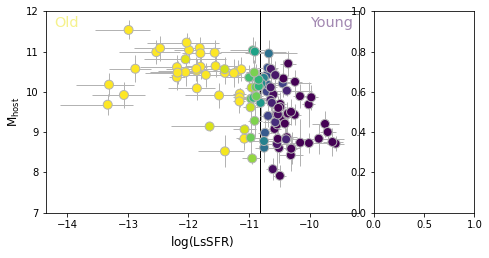

In [9]:
for name, model in zip(mod_name[:2], mod_list[:2]):
    fig = plt.figure(figsize=[7, 3.5], facecolor='w')
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    
    print(name)
    model.show_model_tot(ax=ax)
    plt.title(model.__doc__)
    plt.close()
    
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan_all.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan_all.png',
                bbox_inches='tight', dpi=600)
    
for name, model in zip(mod_name[2:], mod_list[2:]):
    fig = plt.figure(figsize=[7, 3.5], facecolor='w')
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])
 
    print(name)
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-model.amp*np.sum(1-model.py),
                     y_factor=model.amp*np.sum(model.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    axh.set_ylim(*ax.get_ylim())
    axh.set_yticks([])
    axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__)
    plt.close()

    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_hist_SED-nonan_all.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_hist_SED-nonan_all.png',
                bbox_inches='tight', dpi=600)

ValueError: weights should have the same shape as x

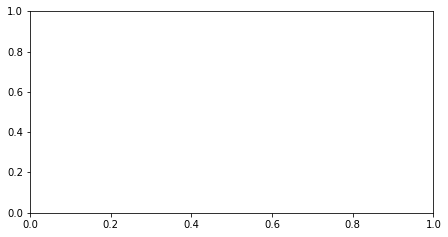

In [10]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
evol3G3M3S.show_hist(ax=ax, bins=15)
evol3G3M3S.show_model(ax=ax,
                 o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                 y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)
 
ax.axvline(0, color='k', lw=1, zorder=10)

#ax.set_xticks([])
ax.set_xlim(-10, 12)
 
ax.set_xlabel(r'$\mathrm{log(LsSFR)}$', fontsize='x-large')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{host}$', fontsize='x-large')

plt.suptitle(evol3G3M3S.__doc__)
 
fig.savefig('../../../Images/pdf/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

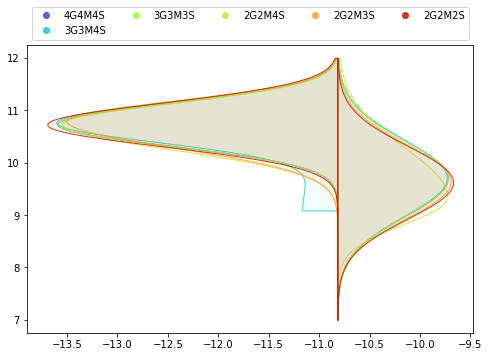

In [15]:
fig = plt.figure(figsize=[10, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#evol4G4M4S.scatter(model=False, ax=ax)
#evol4G4M4S.show_hist(ax, yotext=False, alpha=.1)
evol4G4M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.1, 0.05), eco=plt.cm.turbo(0.1, 0.9),
                      fcy=plt.cm.turbo(0.1, 0.05), ecy=plt.cm.turbo(0.1, 0.9))
                      #o_factor=-evol4G4M4S.amp*np.sum(1-evol4G4M4S.py),
                      #y_factor=evol4G4M4S.amp*np.sum(evol4G4M4S.py))
#evol3G3M4S.show_hist(ax, yotext=False, alpha=0)
evol3G3M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.3, 0.05), eco=plt.cm.turbo(0.3, 0.9),
                      fcy=plt.cm.turbo(0.3, 0.05), ecy=plt.cm.turbo(0.3, 0.9))
                      #o_factor=-evol3G3M4S.amp*np.sum(1-evol3G3M4S.py),
                      #y_factor=evol3G3M4S.amp*np.sum(evol3G3M4S.py))
#evol3G3M3S.show_hist(ax, yotext=False, alpha=0)
evol3G3M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.5, 0.05), eco=plt.cm.turbo(0.5, 0.9),
                      fcy=plt.cm.turbo(0.5, 0.05), ecy=plt.cm.turbo(0.5, 0.9))
                      #o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                      #y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py))
evol2G2M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.6, 0.05), eco=plt.cm.turbo(0.6, 0.9),
                      fcy=plt.cm.turbo(0.6, 0.05), ecy=plt.cm.turbo(0.6, 0.9))
#evol2G2M3S.show_hist(ax, yotext=False, alpha=0)
evol2G2M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.7, 0.05), eco=plt.cm.turbo(0.7, 0.9),
                      fcy=plt.cm.turbo(0.7, 0.05), ecy=plt.cm.turbo(0.7, 0.9))
                      #o_factor=-evol2G2M3S.amp*np.sum(1-evol2G2M3S.py),
                      #y_factor=evol2G2M3S.amp*np.sum(evol2G2M3S.py))
#evol2G2M2S.show_hist(ax, yotext=False, alpha=0)
evol2G2M2S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.9, 0.05), eco=plt.cm.turbo(0.9, 0.9),
                      fcy=plt.cm.turbo(0.9, 0.05), ecy=plt.cm.turbo(0.9, 0.9))
                      #o_factor=-evol2G2M2S.amp*np.sum(1-evol2G2M2S.py),
                      #y_factor=evol2G2M2S.amp*np.sum(evol2G2M2S.py))

from matplotlib.lines import Line2D

evol4G4M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.1,0.9), linewidth=0)
evol3G3M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.3,0.9), linewidth=0)
evol3G3M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.5,0.9), linewidth=0)
evol2G2M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.6,0.9), linewidth=0)
evol2G2M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.7,0.9), linewidth=0)
evol2G2M2Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.9,0.9), linewidth=0)
handles = [evol4G4M4Sleg, evol3G3M4Sleg, evol3G3M3Sleg,
           evol2G2M4Sleg, evol2G2M3Sleg, evol2G2M2Sleg]
labels = ['4G4M4S', '3G3M4S', '3G3M3S', '2G2M4S', '2G2M3S', '2G2M2S']

ax.legend(handles, labels,
          loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/models_mass_hist_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/models_mass_hist_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

### Weird masses to Mat

In [9]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
#sed[(sed['mass'] > 8.2) &
#    (sed['mass'] < 9.)].to_csv('../../../Data/mass/weird_sedsnf.csv', sep=' ')

### Lowz masses to Mat

In [10]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')
lowz_df = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])]
#lowz_df.to_csv('../../../Data/sne/lowz.csv', sep=' ')